In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
import nltk
from collections import Counter
import string
import seaborn as sns
%matplotlib inline

In [5]:
sheet_to_df_map = pd.read_excel('online_retail_II.xlsx', sheet_name=None)
online_retailer = pd.concat(sheet_to_df_map, axis=0, ignore_index=True)

In [6]:
online_retailer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   Invoice      1067371 non-null  object        
 1   StockCode    1067371 non-null  object        
 2   Description  1062989 non-null  object        
 3   Quantity     1067371 non-null  int64         
 4   InvoiceDate  1067371 non-null  datetime64[ns]
 5   Price        1067371 non-null  float64       
 6   Customer ID  824364 non-null   float64       
 7   Country      1067371 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 65.1+ MB


In [7]:
online_retailer.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [8]:
online_retailer.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [9]:
#Understanding and cleaning data
#1. rows with less than 0 quantity, are cancelled orders
online_retailer[online_retailer['Quantity']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321.0,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321.0,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321.0,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321.0,Australia
...,...,...,...,...,...,...,...,...
1065910,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
1067002,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
1067176,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
1067177,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [10]:
# rows with negative price are bad debt adjustments
online_retailer[online_retailer['Price']<0]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
179403,A506401,B,Adjust bad debt,1,2010-04-29 13:36:00,-53594.36,NaN,United Kingdom
276274,A516228,B,Adjust bad debt,1,2010-07-19 11:24:00,-44031.79,NaN,United Kingdom
403472,A528059,B,Adjust bad debt,1,2010-10-20 12:04:00,-38925.87,NaN,United Kingdom
825444,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
825445,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [11]:
#2. remove rows without Customer ID
online_retailer_1=online_retailer.dropna(subset=['Customer ID'])

In [12]:
online_retailer_1.describe()

,Quantity,Price,Customer ID
count,824364.000000,824364.000000,824364.000000
mean,12.414574,3.676800,15324.638504
std,188.976099,70.241388,1697.464450
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13975.000000
50%,5.000000,1.950000,15255.000000
75%,12.000000,3.750000,16797.000000
max,80995.000000,38970.000000,18287.000000


In [13]:
online_retailer_1['Amount']=online_retailer_1['Price'] * online_retailer_1['Quantity']

<ipython-input-13-dfd2739f776c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  online_retailer_1['Amount']=online_retailer_1['Price'] * online_retailer_1['Quantity']


In [15]:
online_retailer_1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [54]:
#Invoice Date splitting
online_retailer_1[["InvYear","InvMonth","InvDay"]]=online_retailer_1["InvoiceDate"].astype(str).str.split("-", expand = True)
online_retailer_1[["InvDay","InvTime"]]=online_retailer_1["InvDay"].astype(str).str.split(" ", expand = True)

C:\Users\rayanoothalav\Anaconda3\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [55]:
online_retailer_1.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Amount,InvYear,InvMonth,InvDay,InvTime
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4,2009,12,01,07:45:00
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,01,07:45:00
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0,2009,12,01,07:45:00
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8,2009,12,01,07:45:00
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0,2009,12,01,07:45:00


In [23]:
# Amount spent by each customer
customer_spending=pd.DataFrame(online_retailer_1.groupby('Customer ID')['Amount'].sum())
customer_spending=customer_spending.rename(columns={'Amount': 'Spending'})
customer_spending=customer_spending.reset_index()
customer_spending.head()

,Customer ID,Spending
0,12346.0,-64.68
1,12347.0,5633.32
2,12348.0,2019.40
3,12349.0,4404.54
4,12350.0,334.40


In [24]:
customer_spending.describe()

,Customer ID,Spending
count,5942.000000,5942.000000
mean,15316.500000,2801.799459
std,1715.451981,13973.922553
min,12346.000000,-25111.090000
25%,13831.250000,325.097500
50%,15316.500000,843.970000
75%,16801.750000,2182.005000
max,18287.000000,598215.220000


In [25]:
customer_spending.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Customer ID  5942 non-null   float64
 1   Spending     5942 non-null   float64
dtypes: float64(2)
memory usage: 93.0 KB


In [ ]:
#5942 customers have spent on average apprx. 2801.80

In [26]:
No_of_times=pd.DataFrame(online_retailer_1.groupby('Customer ID')['InvoiceDate'].nunique())
No_of_times = No_of_times.rename(columns={'InvoiceDate': 'Purchase_Frequency'})
No_of_times = No_of_times.reset_index()
No_of_times.head()

,Customer ID,Purchase_Frequency
0,12346.0,17
1,12347.0,8
2,12348.0,5
3,12349.0,5
4,12350.0,1


In [27]:
No_of_times.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5942 entries, 0 to 5941
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Customer ID         5942 non-null   float64
 1   Purchase_Frequency  5942 non-null   int64  
dtypes: float64(1), int64(1)
memory usage: 93.0 KB


In [28]:
No_of_times.describe()

,Customer ID,Purchase_Frequency
count,5942.000000,5942.000000
mean,15316.500000,7.511612
std,1715.451981,15.836676
min,12346.000000,1.000000
25%,13831.250000,2.000000
50%,15316.500000,4.000000
75%,16801.750000,8.000000
max,18287.000000,508.000000


In [ ]:
#Each customers has purchased on average apprx. 7.5 times in 2 years, minimum 1 and maximum 508 times

In [29]:
segment_1=pd.merge(customer_spending, No_of_times)

In [30]:
segment_1['Spend_per_Inv']=segment_1['Spending']/segment_1['Purchase_Frequency']
segment_1.head()

,Customer ID,Spending,Purchase_Frequency,Spend_per_Inv
0,12346.0,-64.68,17,-3.804706
1,12347.0,5633.32,8,704.165000
2,12348.0,2019.40,5,403.880000
3,12349.0,4404.54,5,880.908000
4,12350.0,334.40,1,334.400000


In [31]:
segment_1.describe()

,Customer ID,Spending,Purchase_Frequency,Spend_per_Inv
count,5942.000000,5942.000000,5942.000000,5942.000000
mean,15316.500000,2801.799459,7.511612,293.967005
std,1715.451981,13973.922553,15.836676,522.891490
min,12346.000000,-25111.090000,1.000000,-25111.090000
25%,13831.250000,325.097500,2.000000,151.050000
50%,15316.500000,843.970000,4.000000,231.915000
75%,16801.750000,2182.005000,8.000000,357.414135
max,18287.000000,598215.220000,508.000000,11880.840000


In [32]:
#293.97 is spend by Each customer on Each purchases on average, 75% of customer purchases are within 357.41 

In [45]:
# Amount spent by Country
spending_by_country=pd.DataFrame(online_retailer_1.groupby('Country')['Amount'].sum())
spending_by_country=spending_by_country.rename(columns={'Amount': 'Revenue'})
spending_by_country=spending_by_country.sort_values('Revenue',ascending=False)
spending_by_country.head(10)

,Revenue
Country,
United Kingdom,1.380642e+07
EIRE,5.785016e+05
Netherlands,5.485250e+05
Germany,4.179886e+05
France,3.265047e+05
Australia,1.671291e+05
Switzerland,9.908281e+04
Spain,9.185948e+04
Sweden,8.745542e+04


<AxesSubplot:ylabel='Country'>

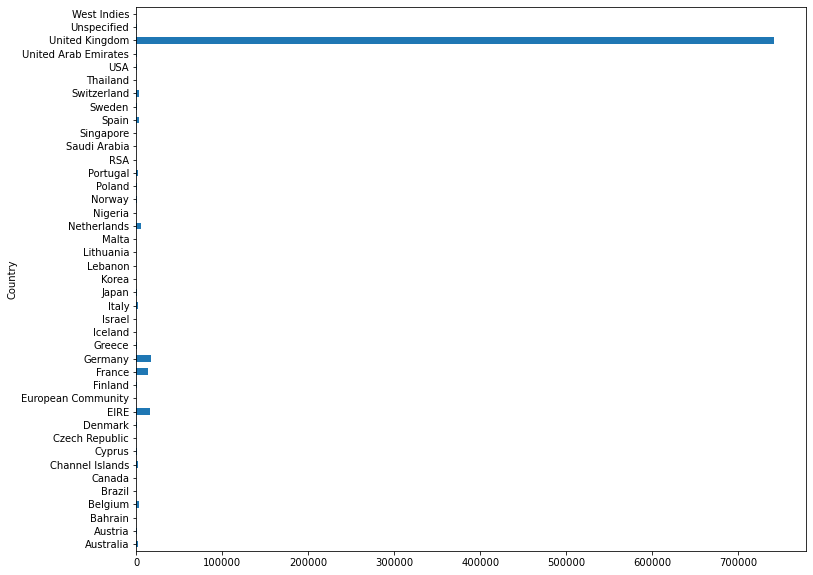

In [35]:
# Customers from each country
plt.figure(figsize=(12,10))
online_retailer_1.groupby('Country').count()['Customer ID'].plot.barh()

In [46]:
# most number of customers are from UK. however, more revenue is generated from UK

In [65]:
# Amount spent by month
monthly_spending=pd.DataFrame(online_retailer_1.groupby('InvMonth')['Amount'].sum())
monthly_spending=monthly_spending.rename(columns={'Amount': 'Monthly Spending'})
monthly_spending.head(12)

,Monthly Spending
InvMonth,
01,1007027.282
02,925945.736
03,1215961.091
04,986682.873
05,1208175.630
06,1179473.070
07,1137024.381
08,1203624.460
09,1712473.673


In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
M=monthly_spending['InvMonth']
Spending=monthly_spending['Monthly Spending']
ax.bar(M,Spending)
plt.show()

In [ ]:
# create the time series subplots
fig,ax =  plt.subplots( 2, 2,
                       figsize = ( 10, 8))
  
sns.lineplot( x = "InvoiceDate", y = "Amount", 
             color = 'r', data = online_retailer_1, 
             ax = ax[0][0])